In [1]:
import os
import time
import random
import string
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt

In [2]:
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch Version: {torch.__version__}")

Is CUDA available: True
PyTorch Version: 1.10.0+cu113


## Dataset files name change

In [4]:
path = r"C:/Piotrek/kod/mask-detection/dataset/Validation/Mask"
files = os.listdir(path)
all_symbols = string.ascii_letters + string.digits


for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, ''.join(["".join(random.sample(all_symbols, 20)), '.jpg'])))

## Data loading

In [37]:
dataset_path = os.path.abspath("dataset")

transforms = tt.Compose([tt.Resize(size=(256, 256)),
                         tt.RandomRotation((-60, 60)),
                         tt.Grayscale(num_output_channels=3),
                         tt.ToTensor()])

test_transforms = tt.Compose([tt.Resize(size=(256, 256)),
                              tt.Grayscale(num_output_channels=3),
                              tt.ToTensor()])


train_dataset = ImageFolder(os.path.join(dataset_path, "Train"), transforms)
test_dataset = ImageFolder(os.path.join(dataset_path, "Test"), test_transforms)
validation_dataset = ImageFolder(os.path.join(dataset_path, "Validation"), test_transforms)

In [38]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, drop_last=True, num_workers=0)

In [39]:
label_map = {0: "mask", 1: "no_mask"}

def show_batch(dataloader):
    for images, labels in dataloader:
        fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)

        for (image, label, axs) in zip(images, labels, axs.flatten()):
            axs.imshow(image.permute(1,2,0).clamp(0,1), cmap='gray')
            axs.set_title(label_map[label.item()])
            axs.axis('off')
        
        break

    plt.show()

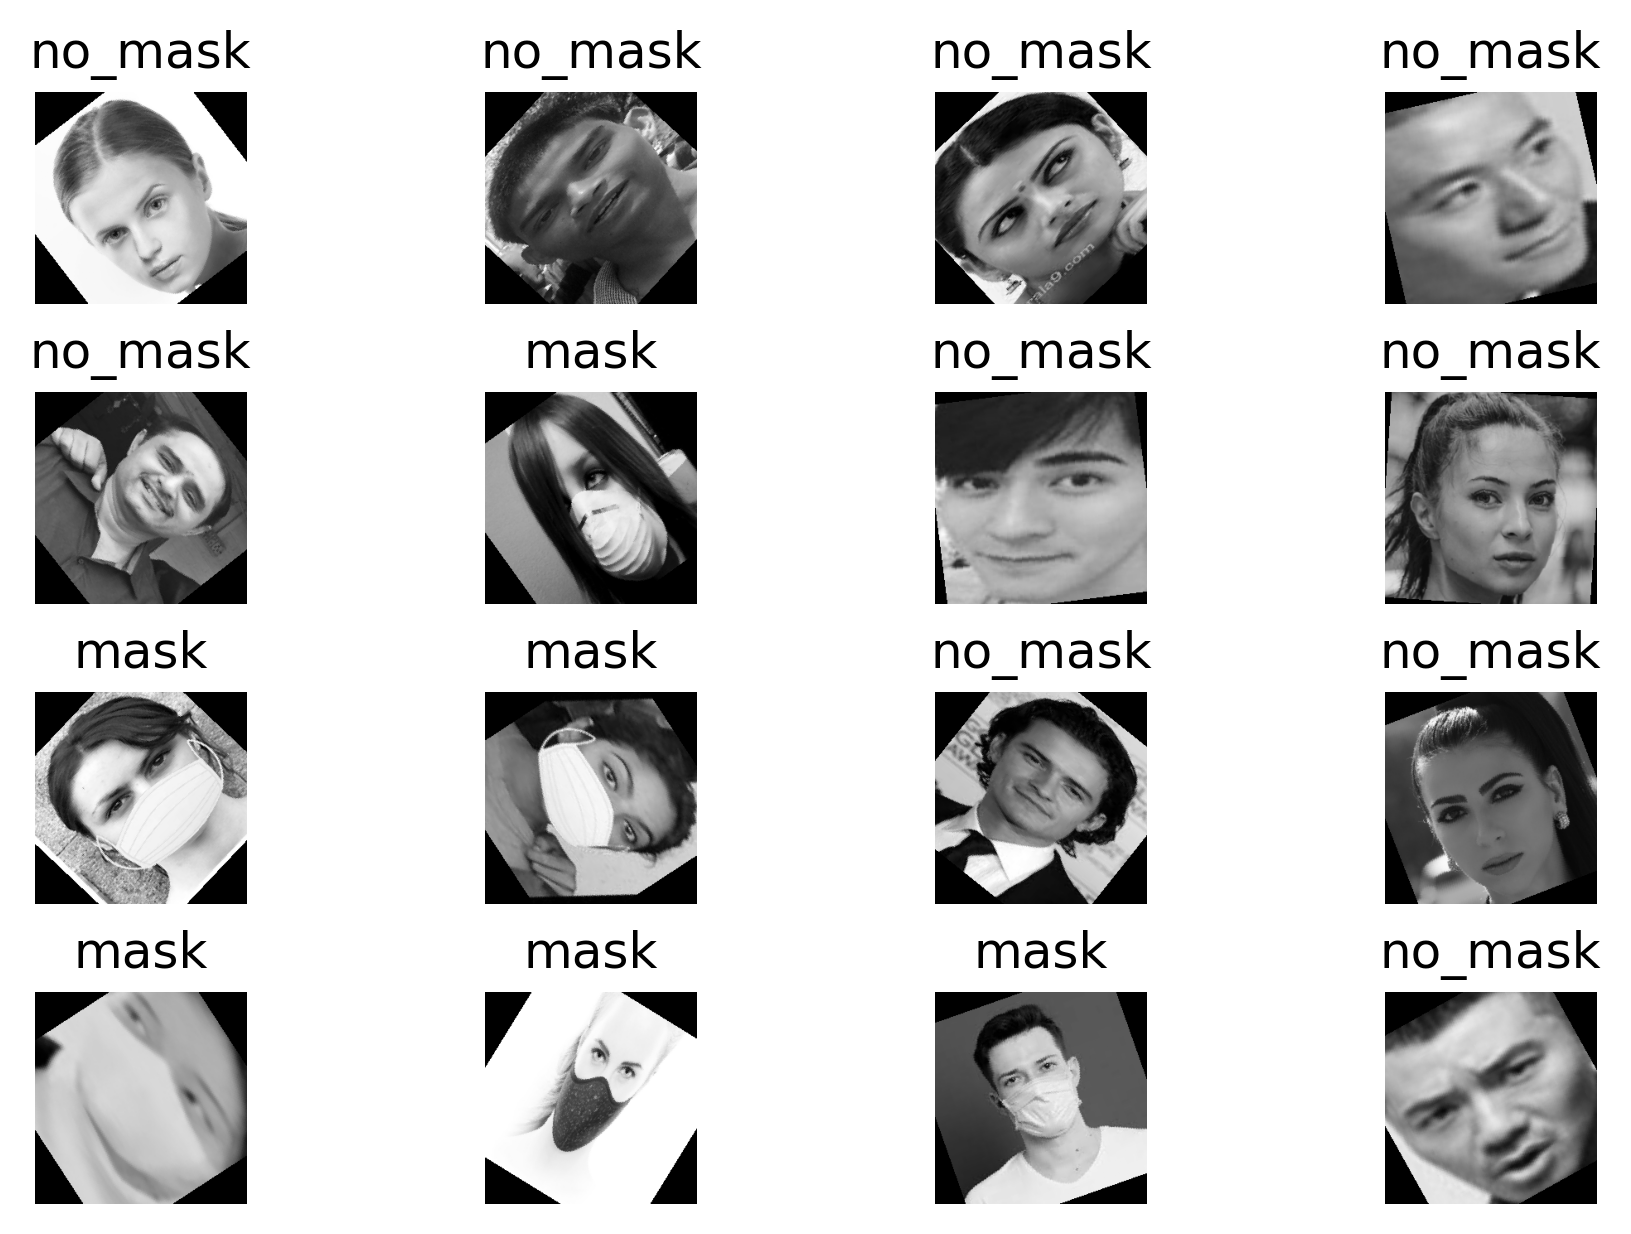

In [40]:
show_batch(train_dataloader)

In [41]:
for images, labels in test_dataloader:
    print(f"Shape of images [N, C, H, W]: {images.shape}")
    print(f"Shape of labels: {labels.shape}, {labels.dtype}")
    break

Shape of images [N, C, H, W]: torch.Size([16, 3, 256, 256])
Shape of labels: torch.Size([16]), torch.int64


In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Pretrained, Resnet18 model

In [43]:
model = torchvision.models.resnet18(pretrained=True, progress=True)

num_outs = model.fc.in_features
model.fc = nn.Linear(num_outs, 2)
model = model.to(device)

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [45]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [46]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>4f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct, test_loss

## Resnet18 training

In [47]:
epochs = 20

start_time = time.perf_counter()

loss = []
accuracy = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    correct, test_loss = test(test_dataloader, model, loss_fn)
    loss.append(test_loss)
    accuracy.append(correct)

time_passed = timedelta(seconds=time.perf_counter() - start_time)

print(f"Done in {time_passed}!")

Epoch 1
-------------------------------
loss: 0.744476  [    0/15118]


C:\Users\zakamycze\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 0.127279  [ 1600/15118]
loss: 0.283346  [ 3200/15118]
loss: 0.112720  [ 4800/15118]
loss: 0.359434  [ 6400/15118]
loss: 0.164546  [ 8000/15118]
loss: 0.286630  [ 9600/15118]
loss: 0.333782  [11200/15118]
loss: 0.241532  [12800/15118]
loss: 0.119272  [14400/15118]
Test Error: 
 Accuracy: 94.356261%, Avg loss: 0.143566 

Epoch 2
-------------------------------
loss: 0.307135  [    0/15118]
loss: 0.239746  [ 1600/15118]
loss: 0.025340  [ 3200/15118]
loss: 0.096974  [ 4800/15118]
loss: 0.132184  [ 6400/15118]
loss: 0.105684  [ 8000/15118]
loss: 0.106669  [ 9600/15118]
loss: 0.032036  [11200/15118]
loss: 0.072934  [12800/15118]
loss: 0.040457  [14400/15118]
Test Error: 
 Accuracy: 95.767196%, Avg loss: 0.110132 

Epoch 3
-------------------------------
loss: 0.018196  [    0/15118]
loss: 0.020471  [ 1600/15118]
loss: 0.046676  [ 3200/15118]
loss: 0.179907  [ 4800/15118]
loss: 0.185745  [ 6400/15118]
loss: 0.013038  [ 8000/15118]
loss: 0.031011  [ 9600/15118]
loss: 0.210113  [11200/151

In [51]:
torch.save(model.state_dict(), "new_model.pth")
print("Saved resnet18 model state to model.pth")

Saved resnet18 model state to model.pth


In [52]:
print(accuracy)
print(loss)

[0.9435626102292769, 0.9576719576719577, 0.981607457797934, 0.9800957420005039, 0.9874023683547493, 0.9685059208868733, 0.9843789367598892, 0.9886621315192744, 0.9848828420256992, 0.9914336104812296, 0.9768203577727387, 0.9868984630889392, 0.9937011841773746, 0.9851347946586042, 0.9944570420760896, 0.9886621315192744, 0.9929453262786596, 0.9909297052154195, 0.9952128999748048, 0.9919375157470396]
[0.14356620726738906, 0.11013158432052156, 0.048810592314464066, 0.057216928023359696, 0.03604929580450839, 0.08574131827727767, 0.043517188348421464, 0.03717848796300645, 0.03491449567897484, 0.025450622027551984, 0.0677254661800215, 0.03185261930922288, 0.021540310851180272, 0.0446444821681648, 0.013682850982434965, 0.03625511367126654, 0.018686682927856905, 0.021752035449733944, 0.015338072508741115, 0.022189481627880387]


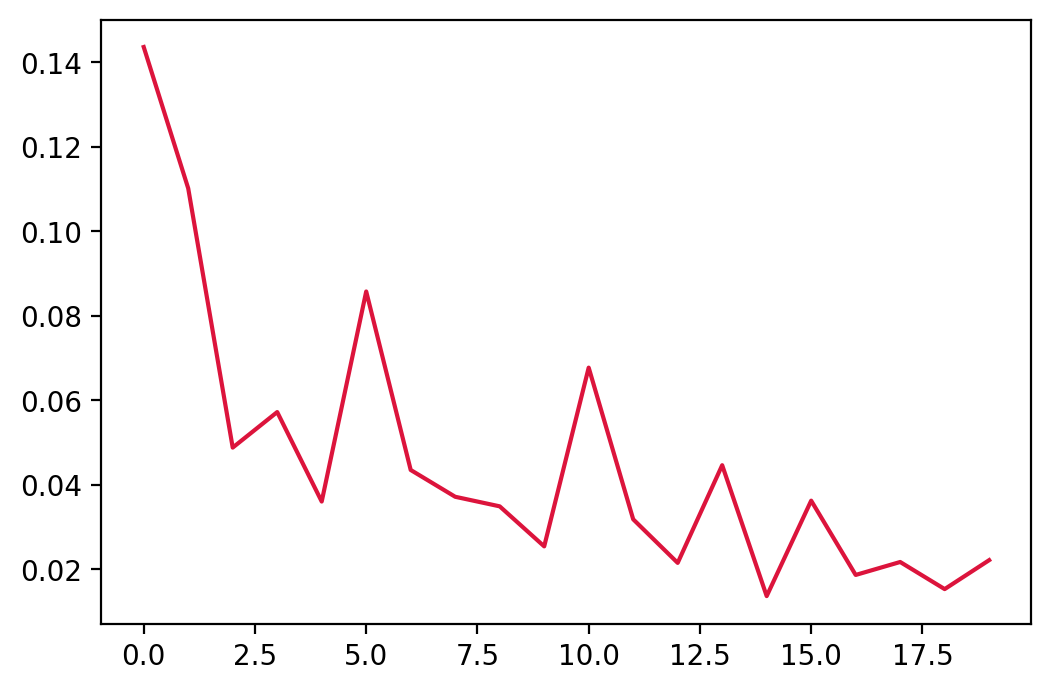

In [53]:
plt.figure(dpi=200)
plt.plot(loss, color="crimson")
plt.show()

## Model state loading

In [29]:
model = torchvision.models.resnet18(pretrained=True)

num_outs = model.fc.in_features
model.fc = nn.Linear(num_outs, 2)
model = model.to(device)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load("model.pth", map_location=device))

<All keys matched successfully>

## Results verification

In [54]:
def predict(tensor, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    prediction = model(tensor.unsqueeze(0))
    prediction = prediction.clone().detach()
    return prediction

In [55]:
classes = ["mask", "no_mask"]

model.eval()

rand_number = random.randint(0, len(validation_dataset))
x, y = validation_dataset[rand_number][0], validation_dataset[rand_number][1]

with torch.no_grad():
    pred = predict(x, model)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: \"{predicted}\", Actual: \"{actual}\"")

Predicted: "mask", Actual: "mask"


In [56]:
classes = ["mask", "no_mask"]

def show_validation(images, labels):
    fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)
    
    for (image, label, axs) in zip(images, labels, axs.flatten()):
        axs.imshow(image.permute(1,2,0).clamp(0,1))
        
        with torch.no_grad():
            pred = predict(image, model)
            predicted, actual = classes[pred[0].argmax(0)], classes[label]
            axs.set_title(f"net:{predicted},\nirl: {actual}", fontsize=10)
        
        axs.axis('off')

    plt.show()

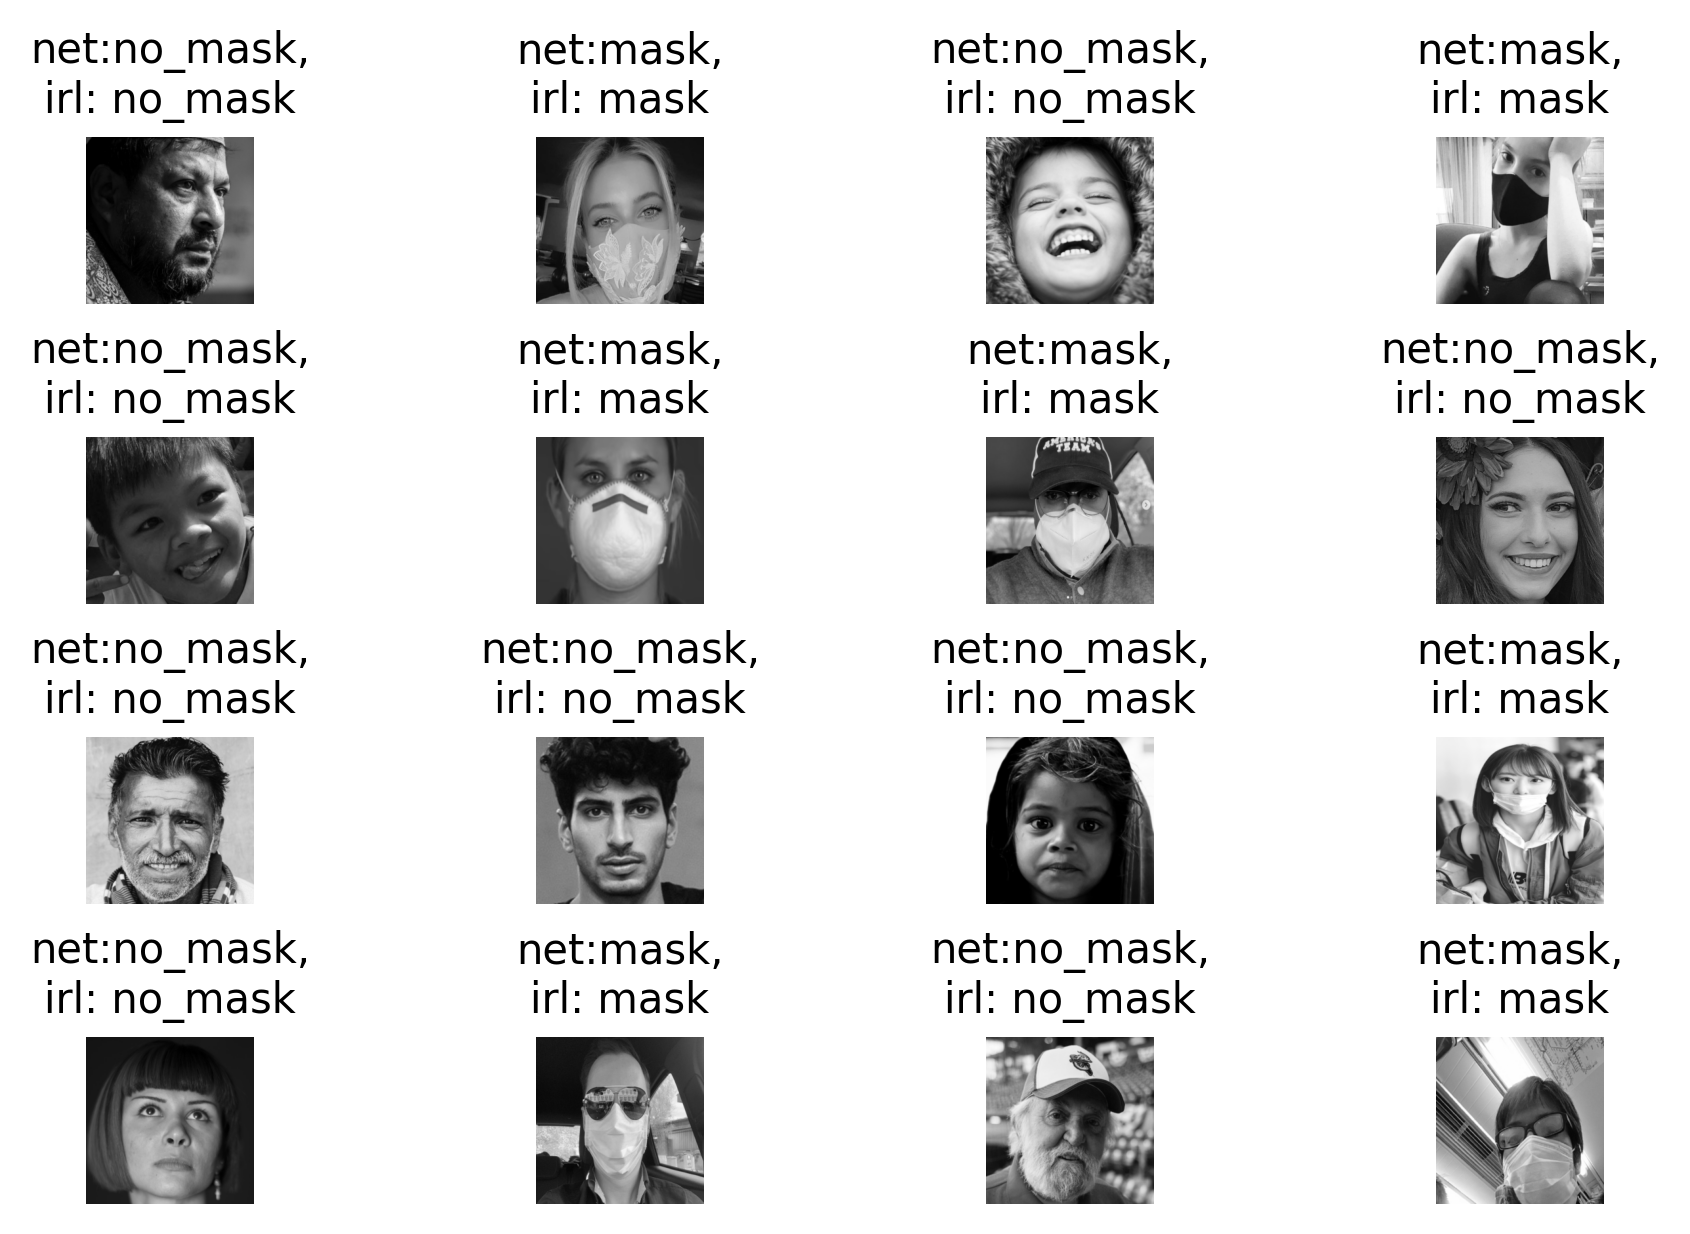

In [57]:
random_nums = [random.randint(0, len(validation_dataset) - 1) for _ in range(batch_size)]
imgs = [validation_dataset[i][0] for i in random_nums]
labls = [validation_dataset[i][1] for i in random_nums]

show_validation(imgs, labls)

In [58]:
with torch.no_grad():
    test(validation_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 99.346405%, Avg loss: 0.008943 

